In [1]:

%pprint
%matplotlib inline
import sys
import os.path as osp

executable_path = sys.executable
scripts_folder = osp.join(osp.dirname(executable_path), 'Scripts'); py_folder = osp.abspath('../py')
if (scripts_folder not in sys.path): sys.path.insert(1, scripts_folder)
if (py_folder not in sys.path): sys.path.insert(1, py_folder)
from jobpostlib import (cu, time, nu, section_classifier_utils, humanize)
from pandas import DataFrame
import pyperclip

Pretty printing has been turned OFF
======== Neo4j/5.24.2 ========
Utility libraries created in 5 seconds


---
# Parts-of-speech Prediction by Logistic Regression Algorithm

In [2]:

# Define a function to fit the classifier and store the results
from sklearn.linear_model import LogisticRegression


## LR Data Preparation
This stage involves preparing the LR dataset for evaluation by transforming the data with a multi-label binarizer.

In [3]:

# Train a model for each labeled POS symbol
import pandas as pd
    
# Check if count_vect has been saved and load it, otherwise create a new one
if nu.pickle_exists('slrcu.count_vect'):
    count_vect = nu.load_object('slrcu.count_vect')
else:
    count_vect = section_classifier_utils.HtmlVectorizer()

# Load or create the TF-IDF transformer
if nu.pickle_exists('slrcu.tfidf_transformer'):
    tfidf_transformer = nu.load_object('slrcu.tfidf_transformer')
else:
    tfidf_transformer = TfidfTransformer(
        norm='l1', smooth_idf=True, sublinear_tf=False, use_idf=True
    )

# Create the logistic regression classifiers
CLASSIFIER_DICT = {}

# Initialize the percent-fit dictionary
POS_PREDICT_PERCENT_FIT_DICT = {}

# Get the labeled training data
pos_df = cu.get_pos_relationships(verbose=False)

In [4]:

# Set aside a balanced validation dataset with 10 records for each pos_symbol
validation_data = []
training_data = []
for pos_symbol in pos_df.pos_symbol.unique():
    pos_symbol_data = pos_df[pos_df.pos_symbol == pos_symbol]
    
    # Sample 10 records for validation (or fewer if there are less than 10 available)
    validation_samples = pos_symbol_data.sample(n=min(10, len(pos_symbol_data)), random_state=42)
    validation_data.append(validation_samples)
    
    # Remaining data is for training
    training_data.append(pos_symbol_data.drop(validation_samples.index))

# Combine validation data and training data into separate data frames
pos_html_strs_df = pd.concat(validation_data)
pos_df = pd.concat(training_data)  # Remaining records in pos_df are the training data

print(f"Validation dataset: {pos_html_strs_df.shape}")
assert pos_df.pos_symbol.unique().shape[0] == pos_html_strs_df.pos_symbol.unique().shape[0], "You don't have a balanced validation set"

Validation dataset: (250, 2)


In [5]:

pos_html_strs_df.sample(min(5, pos_html_strs_df.shape[0]))

,navigable_parent,pos_symbol
17235,<li>Experience with at least one scripting lan...,O-RQ
40155,<b>Benefits Include:</b>,H-SP
47636,At least,O-O
39406,<p>Job type</p>,H-JD
40894,<p>Education:</p>,H-ER


In [6]:

# Fit-transform the Bag-of-words from these hand-labeled HTML strings
sents_list = pos_df.navigable_parent.tolist()
print(f'I have {len(sents_list):,} labeled parts of speech in the training dataset')

# Learn the vocabulary dictionary
bow_matrix = count_vect.fit_transform(sents_list)

# Note: the shape of the Bag-of-words count vector here should be
#       html strings count * unique parts-of-speech tokens count
assert bow_matrix.shape[0] == len(sents_list), "The first dimension of the Bag-of-words count vector does not match the html strings count"
assert len(count_vect.pos_relationships_vocab) == bow_matrix.shape[1], "The second dimension of the Bag-of-words count vector does not match the unique POS tokens count"

# Fit the TF-IDF transformer
X_TRAIN_TFIDF = tfidf_transformer.fit_transform(bow_matrix)

I have 47,599 labeled parts of speech in the training dataset


In [7]:

def build_predict_percent_fit_function(pos_symbol, verbose=False):
    predict_percent_fit = None
    if pos_symbol in CLASSIFIER_DICT:

        def predict_percent_fit(navigable_parent):

            X_test = tfidf_transformer.transform(
                count_vect.transform([navigable_parent])
            ).toarray()
            try:
                y_predict_proba = CLASSIFIER_DICT[pos_symbol].predict_proba(X_test)[0][1]
            except ValueError as e:
                message = str(e).strip()
                print(f"{e.__class__.__name__} error in predict_percent_fit: {message}")
                if "LogisticRegression" in message:
                    print("Try deleting the slrcu_classifier_dict pickle")
                    raise ValueError(f"Try deleting the slrcu_classifier_dict pickle: {navigable_parent}") from e

            return y_predict_proba

    return predict_percent_fit

In [8]:

# Define a function to fit the classifier and assign the results
from sklearn.linear_model import LogisticRegression

def fit_classifier_dict(pos_symbol, X_train_tfidf, train_data_list):
    try:
        
        # Train on initial data
        CLASSIFIER_DICT[pos_symbol].fit(X_train_tfidf, train_data_list)
        
        # Build and assign the prediction function
        inference_func = build_predict_percent_fit_function(
            pos_symbol, verbose=True
        )
        POS_PREDICT_PERCENT_FIT_DICT[pos_symbol] = inference_func
        
    except ValueError as e:
        print(f'Fitting {pos_symbol} had this error: {str(e).strip()}')
        CLASSIFIER_DICT.pop(pos_symbol, None)
        POS_PREDICT_PERCENT_FIT_DICT.pop(pos_symbol, None)

In [9]:

from tqdm import tqdm

# Train logistic regression classifiers for each unique POS symbol in the training data
t1 = time.time()

# Iterate over unique POS symbols in the training data
pos_symbols = pos_df.pos_symbol.unique()
progress_bar = tqdm(pos_symbols, total=pos_symbols.shape[0], desc="Train the POS Classifiers")
for pos_symbol in progress_bar:
    
    # Train the classifier
    mask_series = (pos_df.pos_symbol == pos_symbol)
    train_data_list = mask_series.to_numpy()
    
    # Create a new logistic regression classifier
    if pos_symbol not in CLASSIFIER_DICT:
        CLASSIFIER_DICT[pos_symbol] = LogisticRegression(
            C=375.0, class_weight='balanced', max_iter=1000, penalty='l1',
            solver='liblinear', verbose=False, warm_start=True
        )
        
    fit_classifier_dict(pos_symbol, X_TRAIN_TFIDF, train_data_list)
assert POS_PREDICT_PERCENT_FIT_DICT, "Nothing fitted"

# Parts-of-speech logistic regression model is normally built in 39 minutes and 9 seconds
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
speech_str = f'Parts-of-speech logistic regression model built in {duration_str}'; print(speech_str)

Train the POS Classifiers: 100%|████████████████| 25/25 [25:50<00:00, 62.03s/it]

Parts-of-speech logistic regression model built in 25 minutes and 50 seconds


In [10]:

def predict_single(html_str, verbose=False):
    '''
    Predict the labels for the input data
    '''
    tuple_list = []
    for pos_symbol, predict_percent_fit_fn in POS_PREDICT_PERCENT_FIT_DICT.items():
        if predict_percent_fit_fn is None:
            proba_tuple = (pos_symbol, 0.0)
            tuple_list.append(proba_tuple)
        else:
            proba_tuple = (pos_symbol, predict_percent_fit_fn(html_str))
            tuple_list.append(proba_tuple)
    tuple_list.sort(reverse=True, key=lambda x: x[1])

    return tuple_list[0][0]

In [11]:

# Prepare the comparison data
part_of_speech_dict = pos_html_strs_df.set_index('navigable_parent').pos_symbol.to_dict()
y_actual = [(pos_symbol, ) for pos_symbol in part_of_speech_dict.values()]

In [12]:

t1 = time.time()
y_lr_predicted = [(predict_single(navigable_parent), ) for navigable_parent in part_of_speech_dict.keys()]
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'Predicted labels created in {duration_str}')

Predicted labels created in 25 seconds


In [13]:

import random

# Assuming y_lr_predicted and y_actual are lists or arrays of the same length
data_length = len(y_lr_predicted)

# Generate random indices
random_indices = random.sample(range(data_length), 16)

# Use the indices to display the same samples from both arrays
y_lr_predicted_samples = [y_lr_predicted[i] for i in random_indices]
y_actual_samples = [y_actual[i] for i in random_indices]

# Print or use the samples as needed
print(f"y_lr_predicted Samples:\n{y_lr_predicted_samples}")
print(f"y_actual Samples:\n{y_actual_samples}")

y_lr_predicted Samples:
[('O-SP',), ('O-IP',), ('H-PQ',), ('H-SP',), ('O-RQ',), ('O-OL',), ('O-IP',), ('O-LN',), ('O-RQ',), ('O-RQ',), ('H-CS',), ('O-TS',), ('H-O',), ('O-JD',), ('H-JD',), ('O-PD',)]
y_actual Samples:
[('O-SP',), ('O-IP',), ('H-PQ',), ('H-JT',), ('O-RQ',), ('O-OL',), ('H-OL',), ('O-LN',), ('H-IP',), ('H-O',), ('H-CS',), ('O-TS',), ('H-O',), ('O-JD',), ('H-JD',), ('O-PD',)]


In [14]:

from sklearn.preprocessing import MultiLabelBinarizer

# Create the MultiLabelBinarizer object
mlb = MultiLabelBinarizer()

# Fit and transform the y_test and y_pred sequences
y_actual_transformed = mlb.fit_transform(y_actual)
y_lr_pred_transformed = mlb.transform(y_lr_predicted)
mlb.classes_

array(['H-CS', 'H-ER', 'H-IP', 'H-JD', 'H-JT', 'H-LN', 'H-O', 'H-OL',
       'H-PD', 'H-PQ', 'H-RQ', 'H-SP', 'H-TS', 'O-CS', 'O-IP', 'O-JD',
       'O-JT', 'O-LN', 'O-O', 'O-OL', 'O-PD', 'O-PQ', 'O-RQ', 'O-SP',
       'O-TS'], dtype=object)


## LR Visualization

These metrics are particularly useful in multi-class classification problems and imbalanced datasets.

### Use Cases:
- **High Precision** is important when false positives are costly (e.g., spam email detection — you don't want to mark important emails as spam).
- **High Recall** is important when false negatives are costly (e.g., medical diagnosis — you don't want to miss a disease).
- **F1-Score** is used when you want a balance between precision and recall, especially in cases of imbalanced datasets.
- **Support** is important when the number of actual occurrences of a certain class in the dataset is low enough to need synthetic data to be generated for it.

In [15]:

# Compute the classification report
from sklearn.metrics import classification_report

pos_symbol_lr_df = DataFrame.from_dict(
    classification_report(y_actual_transformed, y_lr_pred_transformed, target_names=mlb.classes_, zero_division=0, output_dict=True),
    orient='index'
)
pos_symbol_lr_df.index.name = 'pos_symbol'
df = pos_symbol_lr_df.sort_values('recall', ascending=False)
display(df)
min_recall_pos_symbol = df.tail(1).index.values[0]
nu.store_objects(min_recall_pos_symbol=min_recall_pos_symbol)

# Make and store report
mask_series = df.index.map(lambda x: '-' in str(x)) & (df.recall < 1.0)
next_report_df = df[mask_series].reset_index()
recall_reports_df = nu.load_object('recall_reports_df')
# pos_symbols_list = sorted(set(recall_reports_df.pos_symbol).union(set(third_report.next_report_df)))
next_column_number = int(sorted(recall_reports_df.columns, key=lambda x: x[::-1])[-1].replace('recall', '')) + 1
recall_reports_df[f'recall{next_column_number}'] = next_report_df.recall
recall_reports_df = recall_reports_df.fillna(1.0).sort_values(recall_reports_df.columns.tolist())
# nu.store_objects(recall_reports_df=recall_reports_df)

,precision,recall,f1-score,support
pos_symbol,,,,
O-IP,0.588235,1.000,0.740741,10.0
O-RQ,0.370370,1.000,0.540541,10.0
O-JD,0.909091,1.000,0.952381,10.0
O-PD,1.000000,1.000,1.000000,10.0
H-PD,0.909091,1.000,0.952381,10.0
O-JT,1.000000,1.000,1.000000,10.0
O-TS,0.642857,0.900,0.750000,10.0
O-CS,0.642857,0.900,0.750000,10.0
O-SP,0.615385,0.800,0.695652,10.0


Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\job-hunting\saves\pkl\min_recall_pos_symbol.pkl


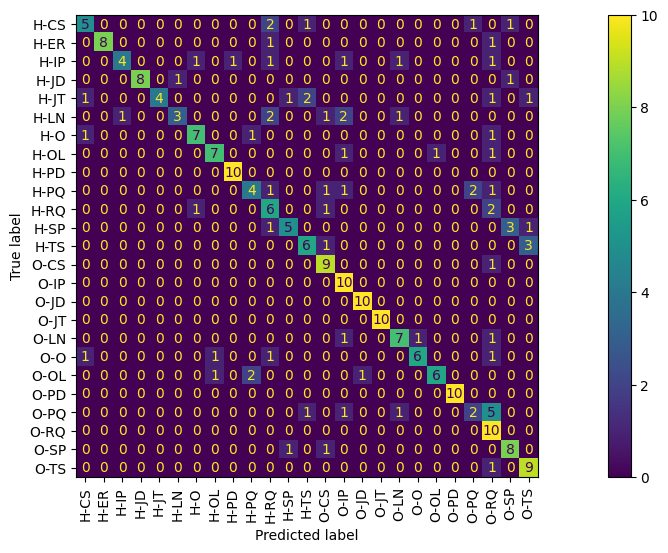

In [16]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels_list = mlb.classes_
cm = confusion_matrix(y_actual, y_lr_predicted, labels=labels_list)
fig, ax = plt.subplots(figsize=(18, 6))
cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax)
xticklabels_list = ax.set_xticklabels(labels_list, rotation='vertical')
yticklabels_list = ax.set_yticklabels(labels_list)


---
# Data Preparation
This stage involves preparing the dataset for comparison by cleaning and pre-processing the data.

In [16]:

import re

# 	    precision	recall	f1-score	support
# pos_symbol
first_report = '''
H-TS	0.642857	0.900	0.750000	10.0
O-SP	0.727273	0.800	0.761905	10.0
O-OL	0.800000	0.800	0.800000	10.0
H-ER	1.000000	0.700	0.823529	10.0
H-CS	0.875000	0.700	0.777778	10.0
H-RQ	0.300000	0.600	0.400000	10.0
H-PQ	0.600000	0.600	0.600000	10.0
H-SP	0.714286	0.500	0.588235	10.0
O-LN	0.500000	0.500	0.500000	10.0
O-O 	1.000000	0.500	0.666667	10.0
H-OL	0.666667	0.400	0.500000	10.0
O-PQ	0.666667	0.400	0.500000	10.0
H-LN	1.000000	0.200	0.333333	10.0
H-JT	1.000000	0.200	0.333333	10.0
H-O 	0.142857	0.100	0.117647	10.0
H-JD	0.500000	0.100	0.166667	10.0
H-IP	0.142857	0.100	0.117647	10.0'''
rows_list = []
for line_str in re.split("[\r\n]+", first_report, 0)[1:]:
    rows_list.append({cn: cv for cn, cv in zip(['pos_symbol', 'precision', 'recall', 'f1-score', 'support'], line_str.split('\t'))})
first_report_df = DataFrame(rows_list)
first_report_df.pos_symbol = first_report_df.pos_symbol.map(lambda x: str(x).strip())
columns_to_convert = ['precision', 'recall', 'f1-score', 'support']
first_report_df[columns_to_convert] = first_report_df[columns_to_convert].astype(float)

In [17]:

second_report = '''
O-RQ	0.428571	0.900000	0.580645	10.0
H-PD	0.900000	0.900000	0.900000	10.0
O-SP	0.500000	0.800000	0.615385	10.0
O-OL	0.888889	0.800000	0.842105	10.0
H-ER	1.000000	0.700000	0.823529	10.0
H-RQ	0.466667	0.700000	0.560000	10.0
O-CS	0.636364	0.700000	0.666667	10.0
H-PQ	0.545455	0.600000	0.571429	10.0
O-LN	0.625000	0.500000	0.555556	10.0
H-JD	0.625000	0.500000	0.555556	10.0
H-CS	0.625000	0.500000	0.555556	10.0
H-OL	0.571429	0.400000	0.470588	10.0
H-IP	0.307692	0.400000	0.347826	10.0
H-JT	1.000000	0.333333	0.500000	9.0
H-TS	0.375000	0.300000	0.333333	10.0
H-SP	0.500000	0.300000	0.375000	10.0
O-O 	1.000000	0.300000	0.461538	10.0
O-PQ	0.500000	0.300000	0.375000	10.0
H-LN	1.000000	0.300000	0.461538	10.0
H-O 	0.000000	0.000000	0.000000	10.0'''
rows_list = []
for line_str in re.split("[\r\n]+", second_report, 0)[1:]:
    rows_list.append({cn: cv for cn, cv in zip(['pos_symbol', 'precision', 'recall', 'f1-score', 'support'], line_str.split('\t'))})
second_report_df = DataFrame(rows_list)
second_report_df.pos_symbol = second_report_df.pos_symbol.map(lambda x: str(x).strip())
columns_to_convert = ['precision', 'recall', 'f1-score', 'support']
second_report_df[columns_to_convert] = second_report_df[columns_to_convert].astype(float)

In [20]:

cypher_str = '''
    // Filter for NavigableParents nodes with an unambiguous SUMMARIZES relationship
    MATCH (np:NavigableParents)
    WHERE size([(np)<-[:SUMMARIZES]-(:PartsOfSpeech) | 1]) = 1
    
    // Find all NavigableParents nodes in the graph with an incoming SUMMARIZES relationship
    WITH np
    MATCH (np)<-[r:SUMMARIZES]-(pos:PartsOfSpeech)
    
    // Group by pos_symbol and collect navigable_parent values
    WITH pos.pos_symbol AS pos_symbol, COLLECT(np.navigable_parent) AS navigable_parents
    
    // Limit to 75 examples per pos_symbol
    WITH pos_symbol, navigable_parents[0..75] AS limited_parents
    
    // Unwind the limited list back into rows
    UNWIND limited_parents AS navigable_parent
    
    // Return the results
    RETURN
        pos_symbol,
        navigable_parent;'''
pyperclip.copy(cypher_str)
row_objs_list = []
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
if row_objs_list:
    pos_html_strs_df = DataFrame(row_objs_list)
    print(pos_html_strs_df.shape) # (75, 30)

(1826, 2)
